In [1]:
import os
import math
import itertools
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import seaborn as sns
from time import time

In [2]:
# Load train dataset
train_data = pd.read_csv('NSL_KDD_Dataset/KDDTrain+.txt', header=None)

# Load test dataset
test_data = pd.read_csv('NSL_KDD_Dataset/KDDTest+.txt', header=None)

print(f"Number of examples in train set: {train_data.shape[0]}")
print(f"Number of examples in test set: {test_data.shape[0]}")

Number of examples in train set: 125973
Number of examples in test set: 22544


In [3]:
#Add labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'class'
,'difficulty_level'])

train_data.columns = columns
test_data.columns = columns


In [94]:
#Sanity check
print(f"Training set:\n")
train_data.head(5)

Training set:



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [7]:
print(f"Test set:\n")
test_data.head(5)

Test set:



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [ ]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,22544.0,218.859076,1407.176612,0.0,0.00,0.00,0.0000,57715.0
src_bytes,22544.0,10395.450231,472786.431088,0.0,0.00,54.00,287.0000,62825648.0
dst_bytes,22544.0,2056.018808,21219.297609,0.0,0.00,46.00,601.0000,1345927.0
land,22544.0,0.000311,0.017619,0.0,0.00,0.00,0.0000,1.0
wrong_fragment,22544.0,0.008428,0.142599,0.0,0.00,0.00,0.0000,3.0
urgent,22544.0,0.000710,0.036473,0.0,0.00,0.00,0.0000,3.0
hot,22544.0,0.105394,0.928428,0.0,0.00,0.00,0.0000,101.0
num_failed_logins,22544.0,0.021647,0.150328,0.0,0.00,0.00,0.0000,4.0
logged_in,22544.0,0.442202,0.496659,0.0,0.00,0.00,1.0000,1.0
num_compromised,22544.0,0.119899,7.269597,0.0,0.00,0.00,0.0000,796.0


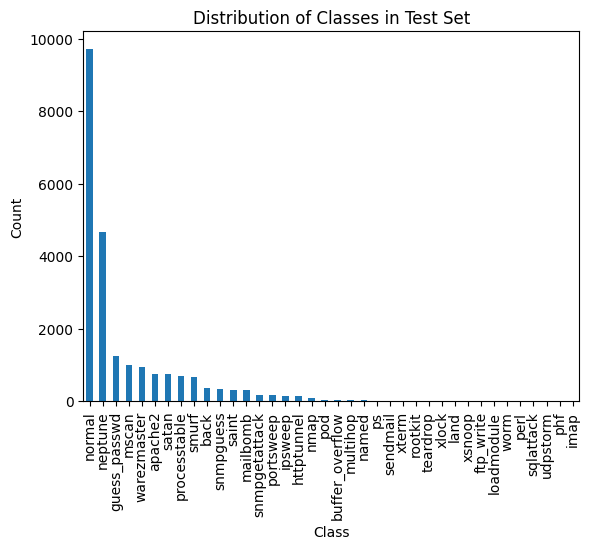

class
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
loadmodule            2
worm                  2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count, dtype: int64


In [15]:
test_data['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print(test_data['class'].value_counts())

In [14]:
#Filter normal data for training
normal_train_data = train_data[train_data["class"] == 'normal']

In [98]:
normal_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,67343.0,168.587396,1304.452127,0.0,0.00,0.00,0.00,40504.0
src_bytes,67343.0,13133.279331,418113.134246,0.0,129.00,233.00,324.00,89581520.0
dst_bytes,67343.0,4329.685223,65462.817703,0.0,105.00,379.00,2056.00,7028652.0
land,67343.0,0.000104,0.010195,0.0,0.00,0.00,0.00,1.0
wrong_fragment,67343.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
urgent,67343.0,0.000148,0.017233,0.0,0.00,0.00,0.00,3.0
hot,67343.0,0.230655,2.308336,0.0,0.00,0.00,0.00,77.0
num_failed_logins,67343.0,0.001381,0.049480,0.0,0.00,0.00,0.00,4.0
logged_in,67343.0,0.710646,0.453466,0.0,0.00,1.00,1.00,1.0
num_compromised,67343.0,0.507076,32.743321,0.0,0.00,0.00,0.00,7479.0


In [99]:
#Check null values on train set
normal_train_data.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [100]:
#Check duplicated values on train set
normal_train_data.duplicated().sum()

np.int64(0)

In [9]:
'''Handle Categorical Features'''

# Filter out columns with type object
categorical_cols = normal_train_data.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'class']  #Exclude class column

#Determine unique values in NORMAL_TRAIN data
for column_name in categorical_cols:
    print(f"Column: {column_name}\n")
    unique_vals = normal_train_data[column_name].unique()
    print(f"Unique Values: ({len(unique_vals)}): {unique_vals}\n") 

## One-hot-Encoding
# Initialize and fit OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_data[categorical_cols])

# Transform categorical columns
encoded_data = encoder.transform(normal_train_data[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=normal_train_data.index)

# Combine with numeric features excluding the difficulty level
numeric_cols = [col for col in normal_train_data.columns if col not in categorical_cols and col != 'class' 
                and col != 'difficulty_level']
normal_train_encoded = pd.concat([normal_train_data[numeric_cols], encoded_df], axis=1)
print(f"Number of features after encoding: {normal_train_encoded.shape[1]}\n")
print(f"Name of encoded features: {encoded_feature_names}\n")

Column: protocol_type

Unique Values: (3): ['tcp' 'udp' 'icmp']

Column: service

Unique Values: (26): ['ftp_data' 'other' 'http' 'telnet' 'domain_u' 'private' 'smtp' 'urp_i'
 'finger' 'ftp' 'ecr_i' 'ntp_u' 'eco_i' 'time' 'auth' 'shell' 'pop_3'
 'IRC' 'red_i' 'domain' 'X11' 'urh_i' 'imap4' 'tim_i' 'ssh' 'tftp_u']

Column: flag

Unique Values: (10): ['SF' 'REJ' 'RSTO' 'S0' 'S1' 'RSTR' 'S3' 'S2' 'OTH' 'SH']

Number of features after encoding: 122

Name of encoded features: ['protocol_type_icmp' 'protocol_type_tcp' 'protocol_type_udp'
 'service_IRC' 'service_X11' 'service_Z39_50' 'service_aol' 'service_auth'
 'service_bgp' 'service_courier' 'service_csnet_ns' 'service_ctf'
 'service_daytime' 'service_discard' 'service_domain' 'service_domain_u'
 'service_echo' 'service_eco_i' 'service_ecr_i' 'service_efs'
 'service_exec' 'service_finger' 'service_ftp' 'service_ftp_data'
 'service_gopher' 'service_harvest' 'service_hostnames' 'service_http'
 'service_http_2784' 'service_http_443' 'service_

In [20]:
train_data['protocol_type'].unique()

unique_rows = normal_train_encoded[['flag_SF','flag_REJ','flag_RSTO','flag_S0','flag_S1','flag_RSTR','flag_S3','flag_S2','flag_OTH','flag_SH']].drop_duplicates()

unique_rows

,flag_SF,flag_REJ,flag_RSTO,flag_S0,flag_S1,flag_RSTR,flag_S3,flag_S2,flag_OTH,flag_SH
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
694,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
976,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
116448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
'''Normalize Numeric Features'''

scaler = MinMaxScaler()
numeric_cols = normal_train_encoded.select_dtypes(include=['int64', 'float64']).columns
normal_train_encoded[numeric_cols] = scaler.fit_transform(normal_train_encoded[numeric_cols])

In [7]:
class AutoEncoder(nn.Module):
    '''
    Design the AutoEncoder Architecture

    Encoder: Compress input data into lower-dimensional representation 
      Input Layer: 122 neurons (number of features after encoding)
      Hidden Layer 1: 64 neurons
      Hidden Layer 2: 32 neurons

    Bottleneck Layer: 16 neurons

    Decoder: Reconstruct the data
      Hidden Layer 3: 32 neurons
      Hidden Layer 4: 64 neurons
      Output Layer: 122 neurons (back to original dimension)

    '''
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(122, 64),   # 122 -> 64 neurons
            nn.ReLU(),   # ReLU activation
            nn.Linear(64,32),   # 64 -> 32 neurons
            nn.ReLU(),   # ReLU activation
            nn.Linear(32, 16),   # 32 -> 16 neurons
            nn.ReLU()   # ReLU activation
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),   # 16 -> 32 neurons
            nn.ReLU(),   # RelU activation
            nn.Linear(32, 64),   # 32 -> 64 neurons
            nn.ReLU(),   # ReLU activation
            nn.Linear(64, 122),   # 64 -> 122 neurons
            nn.Sigmoid()   # Sigmoid activation
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [104]:
#train_set, val_set = train_test_split(normal_train_encoded, test_size=0.2, random_state=42)
#train_set = pd.DataFrame(train_set, columns=normal_train_encoded.columns)
#train_set = np.vstack(train_set.values).astype(np.float32)
#train_tensor = torch.tensor(train_set, dtype=torch.float32)
#train_tensor.type(), train_tensor.shape, train_tensor.dtype


#normal_train_encoded_tensor = torch.tensor(normal_train_encoded.values, dtype=torch.float32)


In [ ]:
''' K-fold Cross-Validation '''

In [10]:
# Initialize KFold with 5 folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Training hyperparameters
batch_size = 32
num_epochs = 100
patience = 5    # Number of events to wait if no improvement
epochs_no_improvement = [] # Store ordinal number of epochs, where the early stopping was triggered
learning_rate = 0.001

# Lists to store validation losses and train losses for each fold
val_losses = []
train_losses = []

# Convert the normal_train_encoded to tensor
normal_train_encoded_tensor = torch.tensor(normal_train_encoded.values, dtype=torch.float32)

In [ ]:
# K-fold cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(normal_train_encoded_tensor)):
    print(f"\nTraining Fold {fold + 1}/{k}")

    # Create training and validation subsets
    train_subset = normal_train_encoded_tensor[train_idx]
    val_subset = normal_train_encoded_tensor[val_idx]

    # Create DataLoaders
    # The input and target are the same for autoencoders, so we use the same dataset for both
    train_dataset = TensorDataset(train_subset, train_subset)  
    val_dataset = TensorDataset(val_subset, val_subset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = AutoEncoder()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for data in train_loader:
            inputs, targets = data

            # Clear gradients for the next batch
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
            
            # Accumulate training loss
            train_loss += loss.item() * inputs.size(0)
    
        # Average training loss
        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()    # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():   # Disable gradient calculation
            for data in val_loader:
                inputs, targets = data
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        # Average validation loss
        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"Best model for fold {fold + 1} with train loss: {train_loss:.8f} and val loss: {best_val_loss:.8f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold + 1}")
                epochs_no_improvement.append(epoch + 1)
                break
    
    # Store the best validation loss and the corresponded train loss for this fold
    val_losses.append(best_val_loss)
    train_losses.append(train_loss)
     
# Print results after training
print("\nK-Fold Cross-Validation Results:")
for fold in range(k):
    print(f"Fold {fold + 1}: Best Validation Loss = {val_losses[fold]:.8f}, Train Loss = {train_losses[fold]:.8f}")

In [ ]:
#num_epochs = np.round(np.mean(np.array(epochs_no_improvement))) if len(epochs_no_improvement) > 0 else num_epochs

#print(num_epochs)
#print(epochs_no_improvement)

55.0
[60, 66, 55, 30, 65]


In [ ]:
''' Retrain the model on the entire training dataset (only with datas flagged as normal) '''

In [11]:
# Create a DataLoader for the entire normal training dataset
full_normal_train_dataset = TensorDataset(normal_train_encoded_tensor, normal_train_encoded_tensor)
full_normal_train_loader = DataLoader(full_normal_train_dataset, batch_size=batch_size, shuffle=True)

# Path to save the model
model_path = 'output/final_model.pth'

# Initialize model, loss, and optimizer
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Number of epochs for retraining
num_epochs = np.round(np.mean(np.array(epochs_no_improvement))) if len(epochs_no_improvement) > 0 else num_epochs
num_epochs = int(num_epochs)

In [ ]:
print(f"Retraining model for {num_epochs} epochs on the entire training dataset.")

# Training loop for the entire dataset
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in full_normal_train_loader:
        inputs, targets = data

        # Clear gradients for the next batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss.item() * inputs.size(0)

    # Average training loss
    train_loss /= len(full_normal_train_loader.dataset)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.8f}')

# Save the model for inference
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [ ]:
''' Evaluation phase on the test set '''

In [12]:
# Compute reconstruction error on normal training data
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for data in full_normal_train_loader:
        inputs, _ = data
        outputs = model(inputs)
        loss = ((outputs - inputs) ** 2).mean(dim=1)    # MSE loss for each sample
        reconstruction_errors.extend(loss.numpy())

# Convert to numpy array
reconstruction_errors = np.array(reconstruction_errors)

# Compute the Anomaly Threshold
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)
threshold = mean_error + 2 * std_error  # 2 standard deviations above the mean
print(f"Anomaly Detection Threshold: {threshold:.4f}")

Anomaly Detection Threshold: 0.2494


In [13]:
''' Preprocess the test set '''

# Identify categorical columns in the test set
# based on the already defined categorical columns in the training set
categorical_cols_test = [col for col in categorical_cols if col in test_data.columns]

# One-hot encode categorical features using the fitted encoder
encoded_data_test = encoder.transform(test_data[categorical_cols_test])
encoded_feature_names_test = encoder.get_feature_names_out(categorical_cols_test)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_feature_names, index=test_data.index)

# Identify numeric columns in the test set
numeric_cols_test = [col for col in test_data.columns if col not in categorical_cols_test and col != 'class' 
                      and col != 'difficulty_level']

# Combine numeric and encoded features
test_encoded = pd.concat([test_data[numeric_cols_test], encoded_df_test], axis=1)

# Add missing columns and reorder to match training data
train_columns = normal_train_encoded.columns
for col in train_columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
test_encoded = test_encoded[train_columns]

# Normalize numeric features in the test set using the same scaler as training set
numeric_cols_test = normal_train_encoded.select_dtypes(include=['int64', 'float64']).columns
test_encoded[numeric_cols_test] = scaler.transform(test_encoded[numeric_cols_test])

# Convert to tensor
test_encoded_tensor = torch.tensor(test_encoded.values, dtype=torch.float32)

# Create DataLoader for the test set
test_data_dataset = TensorDataset(test_encoded_tensor, test_encoded_tensor)
test_data_loader = DataLoader(test_data_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Compute reconstruction error on the test set
reconstruction_test_errors = []
with torch.no_grad():
    for data in test_data_loader:
        inputs, _ = data
        outputs = model(inputs)
        loss = ((outputs - inputs) ** 2).mean(dim=1)
        reconstruction_test_errors.extend(loss.numpy())

reconstruction_test_errors = np.array(reconstruction_test_errors)

In [ ]:
# Classify test samples based on the threshold
# 1 for anomaly, 0 for normal
predictions = (reconstruction_test_errors > threshold).astype(int)

# Calculate Evaluation Metrics
true_labels = (test_data['class'] != 'normal').astype(int)  # 1 for anomaly, 0 for normal

# Compare number of actual instrusion connect and detected intrusion connect
print(f"Actual Intrusion: {sum(true_labels)}, Detected: {sum(predictions)}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(predictions, true_labels, display_labels=['Normal', 'Anomaly'], cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

# Proportion of predicted anomalies that are actually attacks
precision = precision_score(true_labels, predictions)  

# Proportion of actual attacks correctly identified as anomalies
recall = recall_score(true_labels, predictions)

# F1-Score: Harmonic mean of precision and recall
f1 = f1_score(true_labels, predictions)

# Measure of the model's ability to distinguish between normal and attack samples
roc_auc = roc_auc_score(true_labels, reconstruction_test_errors)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Actual Intrusion: 12833, Detected: 55
Confusion Matrix:
[[ 9667    44]
 [12822    11]]

Precision: 0.2000
Recall: 0.0009
F1-Score: 0.0017
ROC AUC: 0.2578
